Autoencoder: 
- unsupervised ML
- special type of NN that encodes (compresses) a dim reduced format of the data and then decodes (reconstructs) it back into an image --> want to minimise reconstruction error
    - determines latent variables for most efficient deconstruxn/reconstruxn

Let's use autoencoders to detect anomalies in ECG data.

## ECG Data Preprocessing

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Dense, Flatten, Reshape


In [3]:
# load dataset
fpath = '../Data/ecg.csv'
df = pd.read_csv(fpath, header=None)
df.head()
df.shape

(4998, 141)

In [4]:
# split feature and target data
# last col is target labels; no col names --> use integer indexing
# .iloc(row:row, col:col) 
data = df.iloc[:, 0:-1]
labels = df.iloc[:, -1] 
print(data.shape, labels.shape)


(4998, 140) (4998,)


In [5]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=40)

After splitting, will normalise the data. MinMax or Standard scaler? 
https://arxiv.org/pdf/2311.04229

In [6]:
# normalise
# transform on train data, fit on train + test data
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [7]:
# convert labels to boolean for easier target separation 
y_train = y_train.astype(bool)
y_test = y_test.astype(bool)

# normal ECG train + test data
norm_train = X_train[y_train]
norm_test = X_test[y_test]
# abnormal ECG train + test data 
abn_train = X_train[~y_train]
abn_test = X_test[~y_test]

# validation step
len(abn_train) + len(norm_train) == len(X_train)

True

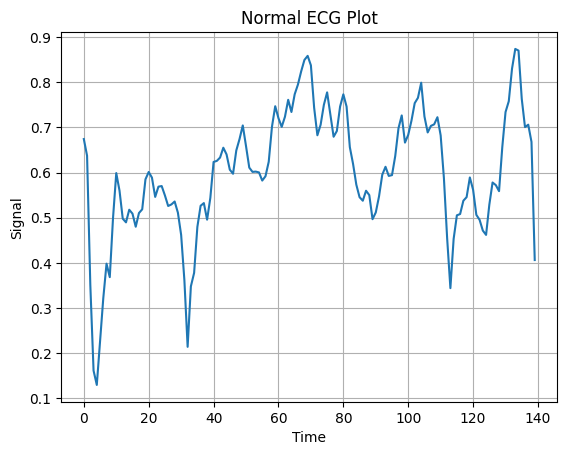

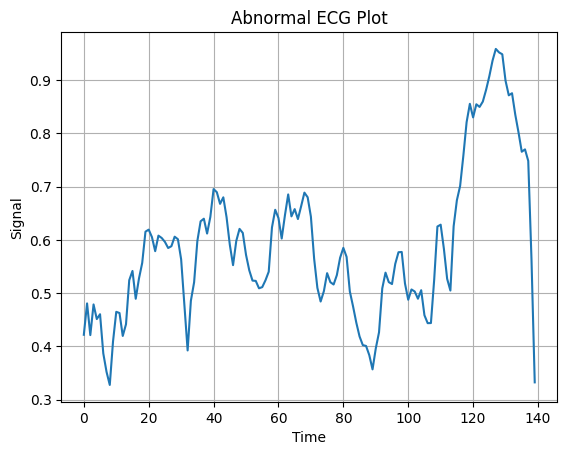

In [8]:
# plot the ECG data
# x = time, y = ECG signal over 140 timepoints
plt.plot(np.arange(140), norm_train[3]) # select a single subject row
plt.grid()
plt.title('Normal ECG Plot')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.show()

plt.plot(np.arange(140), abn_train[2])
plt.grid()
plt.xlabel('Time')
plt.ylabel('Signal')
plt.title('Abnormal ECG Plot')
plt.show()

# Run Model

An autoencoder tries to recreate the input after dimension-reduced storage. \
We want the autoencoder to detect anomalies in the data. \
**reconstruction error** = difference between input and decoded output.\
We will train the autoencoder on only normal ECG data, but present both normal and anomalous ECG test data \
--> reconstruction error should be larger for anomolous ECG data since the autoencoder is not trained for this data shape, resulting in poor reconstruction performance.

We will thus set a reconstruction error threshold to determine 'normal' or 'anomaly' label assignment. 

## Kaser Functional API Model
Functional NN API; can describe layers using common Keras functions and connect input to output, or input to latency. Often used for autoencoders. 

When evaluating reconstruction performance, we want to compare the reconstruction of the input to the input, so the input and examination are the same data twice (norm_train, norm_train; abn_test, abn_test)

In [9]:
# Keras Functional API model
input_layer = Input(shape=(140, 1))

# encode the data
    # Conv1D convolution, filters = number of features to filter down to
    # must connect to input layer  
x = Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(input_layer)
x = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(x)

# flatten + compress 
x = Flatten()(x)   # 2D -> 1D 
latent_layer = Dense(8, activation='relu')(x) # final encoding step

# decode the data; mirrors encoding
# describe all decoding layers 
x = Dense(16, activation='relu')(latent_layer)
x = Dense(32, activation='relu')(x)
decoder_output = Dense(140, activation='sigmoid')(x)  # Match input dimensions; sigmoid gives [0,1] output

# full model instantiation
autoencoder_API = Model(input_layer, decoder_output)
encoder_API = Model(input_layer, latent_layer)

We will now compile the Functional API autoencoder based on normal ECG data only.

In [10]:
# compile + train
autoencoder_API.compile(
    optimizer = 'adam', # standard optimiser 'adaptive learning rate optimizer'
    loss = 'mse') #mse for reconstruction error

# reshape our data to samples, timesteps, channels as Conv1D expects 3D input
norm_train_API = norm_train.reshape(-1, 140, 1)
norm_test_API = norm_test.reshape(-1, 140, 1)

abn_train_API = abn_train.reshape(-1, 140, 1)
abn_test_API = abn_test.reshape(-1, 140, 1)
# verify 
print(norm_train_API.shape, norm_test_API.shape)

(2340, 140, 1) (579, 140, 1)


Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0176 - val_loss: 0.0061
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0046 - val_loss: 0.0042
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0027 - val_loss: 0.0027
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 9/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 10/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 11/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 12/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.002

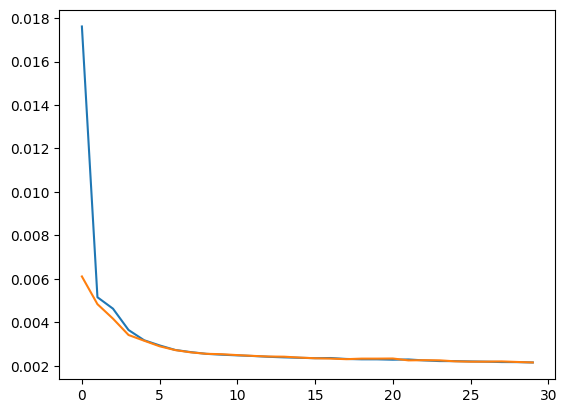

In [11]:
history_metrics = autoencoder_API.fit(
    norm_train_API, norm_train_API, # check against itself for reconstruction error
    epochs = 30, # iterations
    batch_size=32, # num of samples per gradient update
    validation_data= (norm_test_API, norm_test_API),
    shuffle=True, # randomise traiing order per epoch
    verbose=1
)
# the output of API.fit() is history = loss metrics for each epoch/iteration of the training

# plot history metrics
plt.plot(history_metrics.history['loss'])
plt.plot(history_metrics.history['val_loss'])
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


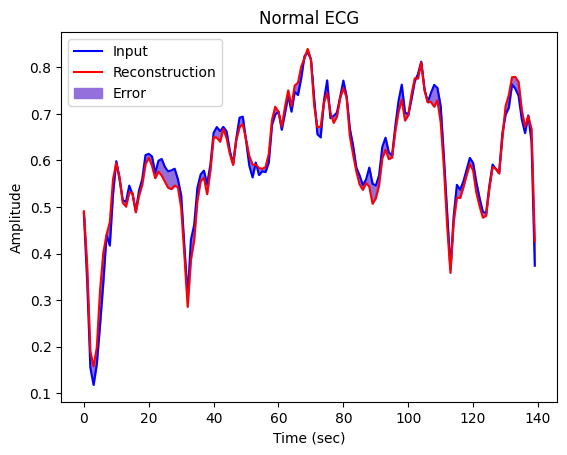

In [32]:

# reconstruction via predict
reconstructed = autoencoder_API.predict(norm_test_API)

def plot(raw_data, n, reconstruction):
    # original data in blue line
    plt.plot(raw_data[n].flatten(), 'b') # flatten to vector if not already 
    # decoded image in red line
    plt.plot(reconstruction[n], 'r')
    # reconstruction error as bw-line fill 
    plt.fill_between(np.arange(140), raw_data[n].flatten(), reconstruction[n], color='mediumpurple')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.ylabel('Amplitude')
    plt.xlabel('Time (sec)')

plot(norm_test_API, 0, reconstructed)
plt.title("Normal ECG")
plt.show()


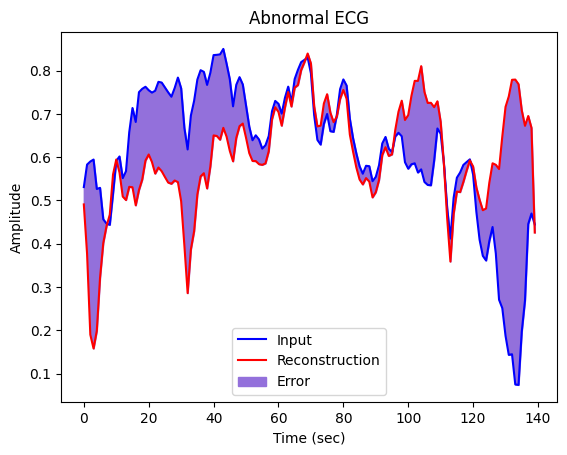

In [33]:
plot(abn_test_API, 0, reconstructed)
plt.title("Abnormal ECG")
plt.show()

## Kaser Model Subclassing
*Sequential API* = like simple end-to-end pipeline with only 1 channel; it cannot manage multiple inputs/outputs. 

The following uses the Sequential API, but subclassing allows manual passing bw encoder + decoder layers, affording better control. This method requires writing logic of the class.\
Sequential Documentation: https://keras.io/guides/sequential_model/

In [35]:
class Autoencoder(Model): # using Keras Model class as template
    def __init__(self): # instantiation 
        super(Autoencoder, self).__init__() # calls Model's instantiation
        self.encoder = tf.keras.Sequential([
            # layering to compress fetaures to 32 -> 16 -> 8
            layers.Dense(32, activation='relu'), 
            # relu = Rectified Linear Unit; converts negatives to 0; improves training clarity + speed  
            layers.Dense(16, activation='relu'),
            layers.Dense(8, activation='relu')
        ])
            # layering to reconstruct; final layer has same # of features as input
        self.decoder = tf.keras.Sequential([
            layers.Dense(16, activation='relu'),
            layers.Dense(32, activation='relu'),
            # started w 140 features -> final layer 140 
            layers.Dense(140, activation='sigmoid') 
            # output as Sigmoid [0,1] 

        ])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

decoder output activation=:
- sigmoid [0 1] (0-1 normalised data)
- tanh [-1 1]
- NA for linear output/any range output  (standardised data)


In [36]:
# instantiate/compile, fit 
autoencoder=Autoencoder()
autoencoder.compile(optimizer='adam', loss='mae')
autoencoder.fit(norm_train, norm_train, # compare against itself 
                epochs=20, # iterations
                batch_size=512, validation_data=(norm_test, norm_test))

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - loss: 0.1413 - val_loss: 0.1361
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.1343 - val_loss: 0.1283
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1261 - val_loss: 0.1196
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1169 - val_loss: 0.1099
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.1068 - val_loss: 0.0993
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0959 - val_loss: 0.0884
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0852 - val_loss: 0.0780
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0751 - val_loss: 0.0690
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0668 - val_loss: 0.0621
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0607 - val_loss: 0.0570
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0561 - val_loss: 0.0532
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0526 - val_loss: 0.0504


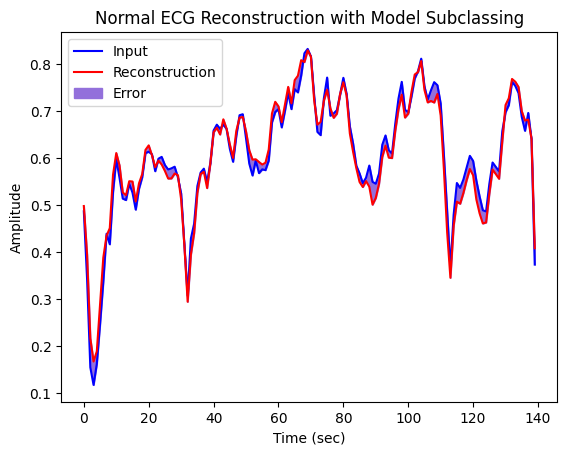

In [42]:
# define fucntion to plot original ECG & reconstructed ECG w error
def plot(data, n, fig_title):
    encoded_img = autoencoder.encoder(data)
    decoded_img = autoencoder.decoder(encoded_img)
    # original data in blue line
    plt.plot(data[n], 'b') 
    # decoded image in red line
    plt.plot(decoded_img[n], 'r')
    # recondstruction error as bw-line fill 
    plt.fill_between(np.arange(140), data[n], decoded_img[n], color='mediumpurple')
    plt.legend(labels=['Input', 'Reconstruction', 'Error'])
    plt.xlabel('Time (sec)')
    plt.ylabel('Amplitude')
    plt.title(fig_title)
    plt.show()


plot(norm_test, 0, 'Normal ECG Reconstruction with Model Subclassing')

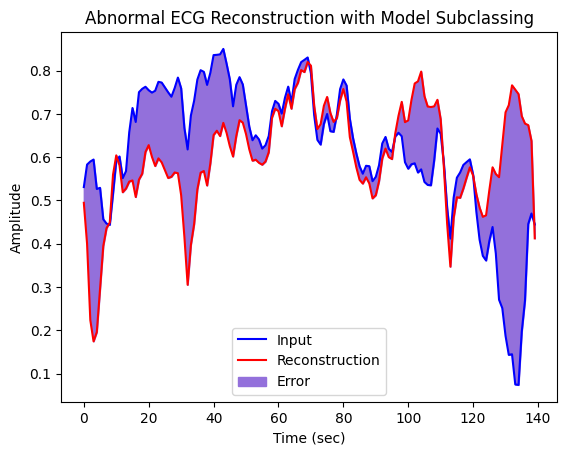

In [43]:
plot(abn_test, 0, 'Abnormal ECG Reconstruction with Model Subclassing')